# It's a Start

### Imports

In [84]:
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt

### General helpers

In [85]:
def random_stream_of_numbers(seed, n_streams):
    seed_seq = np.random.SeedSequence(seed)
    return seed_seq.spawn(n_streams)

def distribution_plot(samples, bins=100, figsize=(5,3)):
    '''
    TODO: This function is fully copied from elsewhere, so we should give credit if we decide to keep it.

    Helper function to visualise the distributions
    
    Params:
    -----
    samples: np.ndarray
        A numpy array of quantitative data to plot as a histogram.
        
    bins: int, optional (default=100)
        The number of bins to include in the histogram
        
    figsize: (int, int) (default=(5,3))
        Size of the plot in pixels
        
    Returns:
    -------
        fig, ax: a tuple containing matplotlib figure and axis objects.
    '''
    hist = np.histogram(samples, bins=np.arange(bins), 
                        density=True)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    _ = ax.plot(hist[0])
    _ = ax.set_ylabel('p(x)')
    _ = ax.set_xlabel('x')
    
    return fig, ax



def generate_samples(dist_type, count, seed, **kwargs):
    '''Generates a single random sample from the specified distribution.
    
    Params:
        - dist_type: str    (normal, poisson, uniform, etc)
        - seed: int         (for RNG)
        - **kwargs: dict    (distribution params like loc for normal and lam for poisson)

    Returns:
        One or many sampled values (float).

    Usage examples:
        sample_normal = generate_samples("normal", 1, 42, loc=5, scale=1)   <-- [5.30471708]
        samples_poisson = generate_samples("poisson", 3, 42, lam=10)        <-- [13  6  9]
    '''

    rng = np.random.default_rng(seed)

    if (dist_type == "normal"):
        # As default, mean=25.0 and std=0.5. This is arbitrary.
        loc = kwargs.get("loc", 25.0)
        scale = kwargs.get("scale", 0.5)
        samples = rng.normal(loc=loc, scale=scale, size=count)
    elif (dist_type == "poisson"):
        # As default, lambda = 10.
        lam = kwargs.get("lam", 10)
        samples = rng.poisson(lam=lam, size=count)
    elif (dist_type == "uniform"): 
        # As default, low=0 and high=1.
        low = kwargs.get("low", 0.0)
        high = kwargs.get("high", 1.0)
        samples = rng.uniform(low=low, high=high, size=count)
    else:
        raise ValueError(f"Not yet implemented: {dist_type}\n")

    return samples

    

#### Example usage of the helper functions for demonstration (I'll take this out later)

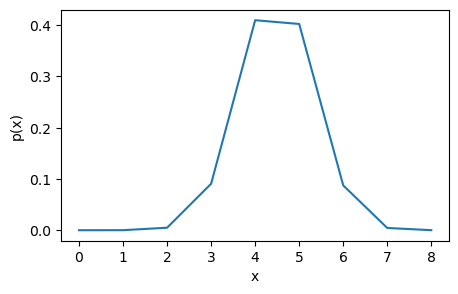

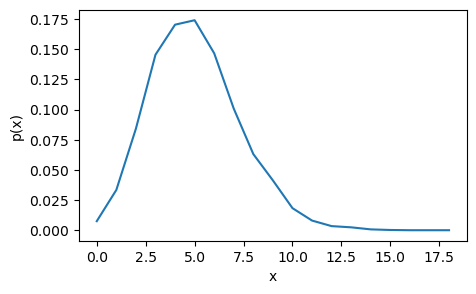

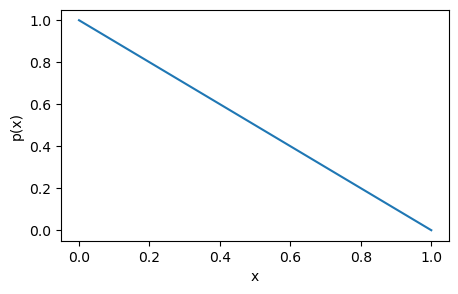

In [86]:
samples_normal  = generate_samples("normal",    10000, 42,  loc=5, scale=0.75)
samples_poisson = generate_samples("poisson",   10000, 42,  lam=5)
samples_uniform = generate_samples("uniform",   10000, 42,  low=0, high=1)
_ = distribution_plot(samples_normal, bins=10)
_ = distribution_plot(samples_poisson, bins=20)
_ = distribution_plot(samples_uniform, bins=3) # Not a great way to plot this.

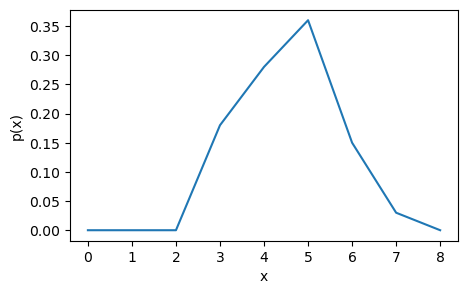

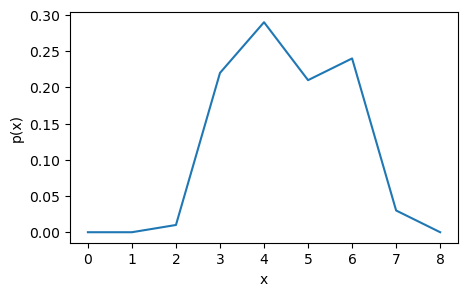

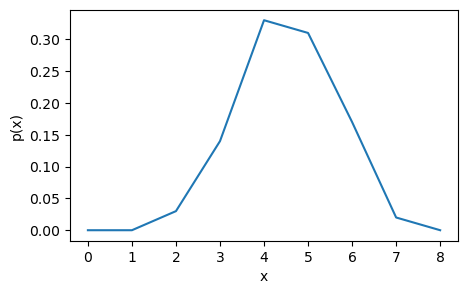

In [87]:
how_many = 3
randstream = random_stream_of_numbers(42, how_many)

rng_1 = np.random.default_rng(randstream[0])
rng_2 = np.random.default_rng(randstream[1])
rng_3 = np.random.default_rng(randstream[2])
rngs = [rng_1, rng_2, rng_3]

for i in range(how_many):
    dist = rngs[i].normal(loc=5, scale=1, size=100)
    _ = distribution_plot(dist, bins=10)


---

## AND NOW BACK TO THE SUBJECT AT HAND: The Café...

As we don't have all of the facts / estimates yet, I'll have to take... creative liberties.

I'll say that the café is open from 06:30 to 15:30, that the main rush hour is between 8 and 9, and that there's then another lesser rush during lunch (11:30 to 13:00).

So, essentially:

| Time | Customers per hour (arrival rate (lambda)) |
| ---- | ------------------------------------------ |
| 06:30 - 08:00 | 10 |
| 08:00 - 09:00 | 50 (rush) |
| 09:00 - 11:30 | 20 |
| 11:30 - 13:00 | 40 (lesser rush) |
| 13:00 - 15:30 | 15 |

... so this would be a "non-homogeneous" Poisson process, which SimPy DOES NOT have built in. So I'll be implementing it.

In [88]:
rates = {
    90: 10/60,  # 06:30 - 08:00 --> 90 minutes. 
    150: 50/60, # 08:00 - 09:00 --> 90+60 = 150 minutes
    330: 20/60, # And so on.
    390: 40/60, 
    540: 15/60  # - 15:30, end of day.
}
closing_time = 540

### Metrics that I'm going to keep track of: a checklist.

1) How long customers have to wait, from when they arrive at the café to when they pick up their order.
    - Would also be nice to see how long customers wait in each "act" (waiting to order + ordering, waiting for their order, picking up their order).  
2) How well all resources are utilized (employees in particular), how much idle time they have.

In [89]:
class Stats:
    def __init__(self):
        # CUSTOMER TIME-TRACKING
        self.register_queue_time = []       # Time each customer spent waiting to place their order.
        self.pickup_queue_time = []         # Time each custimer spent picking up their order.
        self.total_time_in_system = []      # Total time each customer spent from arrival time to pickup time.
        # Experimenting:
        self.time_until_prep_begins = []    # The time from the customer places the order until a barista begins working on it.

        # QUEUE TRACKING
        self.number_in_register_queue = []  # Avgerage number for several different spans of time.
        self.number_waiting = []            # Same but for the people waiting.
        self.number_in_pickup_queue = []    # Same but for the people picking their order up.

        # TODO: RESOURCE UTILIZATION


### Café-specific helpers

In [90]:
# Once again, we have yet to pin down the service time distribution,
# but to start implementing I'll just assume that it takes at least 5 seconds
# and that the mean is 45 seconds with a standard deviation of 10. Or something.
def order_time(rng):
    '''How long it takes a customer to order, in seconds.'''
    return max(5, rng.normal(45, 10)) 



# ... it's gotta take at least 5 seconds, that's if you're just taking out a croissant and putting it on a dish or something.
# I'll just take a wild guess of 3 minutes (180 seconds) as the mean and 20 seconds as the standard deviation.
# Also I added the time it takes to pay. 
def making_order_time(rng):
    '''How long it takes to get the order ready.
    TODO: We might want to change this process later, add coffe machines and such as resources, and so on.
    For now though, it's just a distribution like so.'''

    #       Time taken to order             Time taken to pay
    return (max(10, rng.normal(180, 20)) + max(3, rng.normal(7, 3)))



# It's gotta take at least a second.
# I'm just going to be optimistic and guess that the mean is 5 seconds, and the std is 1.
def pickup_time(rng):
    '''How long it takes the customer to pick up the order.'''
    return max(1, rng.normal(5, 1))

#### asdfghjk

In [91]:

def arrivals_generator(env, stats_keeper, register, barista, pickup, rates, closing_time, seed=None):
    '''
    Generates customer arrival times using a
        PIECEWISE-CONSTANT NON-HOMOGENEOUS POISSON PROCESS.

    Params:
        - env:      simpy.Environment.
        - rates:    a dictionary, the keys being time passed (breakpoints) in minutes 
                    and the values being arrival rates.
        - seed:     int, seed for RNG.

    Returns:
        - Arrivals. Floats.
    '''

    rng = np.random.default_rng(seed)
    breakpoints = sorted(rates.keys())

    def get_rate(time):
        '''Returns arrival rate for current time, however we defined it.'''
        for point in breakpoints:
            if (time < point):
                return rates[point]
        return rates[breakpoints[-1]] # If past all, just use the last one.


    customer_ID = 0
    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= closing_time):
            print(f"\nCLOSING SHOP. \nNo more arrivals after closing at {closing_time:.2f}.\n")
            return

        rate = get_rate(env.now)                    # Rate at this time.

        inter_arrival = rng.exponential(1 / rate)   # Inter arrival from exponential dist.
        yield env.timeout(inter_arrival)            # Waiting until the next arrival.

        env.process(customer(
            env, 
            stats_keeper,
            customer_ID, 
            register, 
            barista,
            pickup,
            rng
        ))
        customer_ID += 1





def customer(env, stats_keeper, ID, register, barista, pickup, rng):
    '''Customer's "lifecycle".
    They arrive, wait in line, order + pay, wait for their order, and then pick up their order.
    
    Params:
        - env:          simpy.Environment.
        - ID:           int, customer's ID.
        - register:     int, ID of the register they queue at.
        - rng:          RNG.

    Returns:
        - everlasting happiness

    '''

    arrival = env.now
    print(f'{ID} arrives at {arrival:.2f}')

    # TODO: I could refactor these "acts" into different function. For readibility. 

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    with (register.request() as req):
        yield req # Waiting in line.

        start_ordering = env.now

        print(f"{ID} begins ordering at {start_ordering:.2f}")

        # We wait while the customer places their order.
        ordering = order_time(rng)
        yield env.timeout(ordering)

        stop_ordering = env.now
        print(f"{ID} finishes ordering at {stop_ordering:.2f}")

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    with (barista.request() as req):
        yield req

        prep_time = making_order_time(rng)
        prep_begin = env.now
        print(f"{ID}'s order preperation begins at {prep_begin:.2f}")

        yield env.timeout(prep_time)
        time_ready = env.now
        print(f"{ID}'s is ready for pickup at {time_ready:.2f}")


    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # #
    with pickup.request() as req:
        yield req

        start_pickup = env.now
        print(f"{ID} goes to pick up their order at {start_pickup:.2f}")

        pickupp_time = pickup_time(rng)
        yield env.timeout(pickupp_time)

        end_time = env.now
        print(f"{ID} leaves at {end_time:.2f}")

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    time_in_register_queue = (start_ordering - arrival)
    time_in_pickup_queue = (time_ready - start_pickup)
    total_time = end_time - arrival
    stats_keeper.register_queue_time.append(time_in_register_queue)  # TODO: Do we maybe want :.2f?
    stats_keeper.pickup_queue_time.append(time_in_pickup_queue)
    stats_keeper.total_time_in_system.append(total_time)

    time_from_order_to_prep_start = time_ready - prep_begin
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)


#### Defining resources and such.

In [92]:
env = simpy.Environment()

num_registers = 1
num_baristas = 2
num_pickups = 1

statistics = Stats()

register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
pickup = simpy.Resource(env, capacity=num_pickups)          # One can pick up their order at a time.

env.process(arrivals_generator(
    env=env, 
    stats_keeper=statistics,
    register=register, 
    barista=barista,
    pickup=pickup,
    rates=rates, 
    closing_time=closing_time,
    seed=360
))
env.run(until=1000)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.


0 arrives at 2.90
0 begins ordering at 2.90
1 arrives at 10.67
2 arrives at 16.23
3 arrives at 18.49
4 arrives at 20.84
5 arrives at 21.08
6 arrives at 37.41
7 arrives at 42.86
0 finishes ordering at 44.67
0's order preperation begins at 44.67
1 begins ordering at 44.67
8 arrives at 53.96
9 arrives at 72.50
10 arrives at 74.31
11 arrives at 74.54
12 arrives at 81.09
13 arrives at 87.46
1 finishes ordering at 88.27
1's order preperation begins at 88.27
2 begins ordering at 88.27
14 arrives at 95.65
15 arrives at 97.07
16 arrives at 102.29
17 arrives at 102.41
18 arrives at 103.23
19 arrives at 104.46
20 arrives at 104.89
21 arrives at 105.02
22 arrives at 109.22
23 arrives at 109.58
2 finishes ordering at 110.40
3 begins ordering at 110.40
24 arrives at 111.45
25 arrives at 111.96
26 arrives at 112.90
27 arrives at 114.43
28 arrives at 115.23
29 arrives at 116.16
30 arrives at 116.43
31 arrives at 117.04
32 arrives at 118.26
33 arrives at 120.78
34 arrives at 121.84
35 arrives at 122.12

#### Now checking the stats.

In [93]:
print("Total times in register queue:\n", statistics.register_queue_time)
print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
print("Total times in pickup queue:\n", statistics.pickup_queue_time)
print("Total times in system:\n", statistics.total_time_in_system)

Total times in register queue:
 [0.0, 33.99450481726547, 72.04571357193163, 91.90815775522, 137.06695156302592, 164.01066137648004, 169.17265729264338, 205.31899761978113, 239.26819283668635]
Time from when the order is placed until a barista begins working on it:
 [175.46491668519067, 193.38719491751027, 187.87699054472859, 202.0904407133081, 203.03489162049766, 191.59910556751078, 172.7962548920077, 190.58679088333793, 168.1939674133473]
Total times in pickup queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total times in system:
 [220.17948490611238, 274.3107123527191, 397.22174450414354, 471.1209332537287, 594.9341759800101, 659.9788091186014, 752.6203913618342, 826.4007094354606, 903.0399598933511]


#### Doing some very clever calculations with those stats, or making graphs or whatever.

Plot:

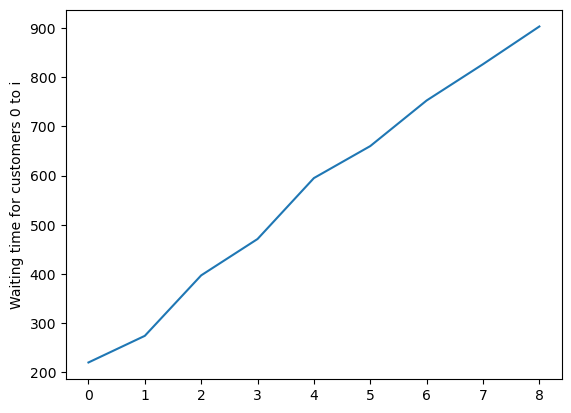

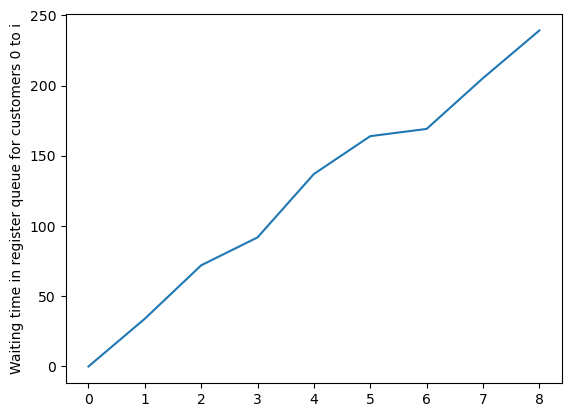

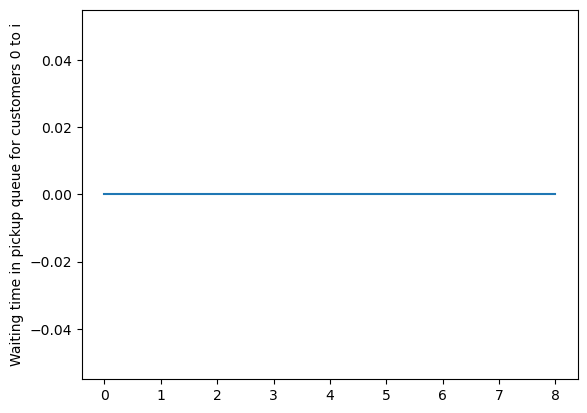

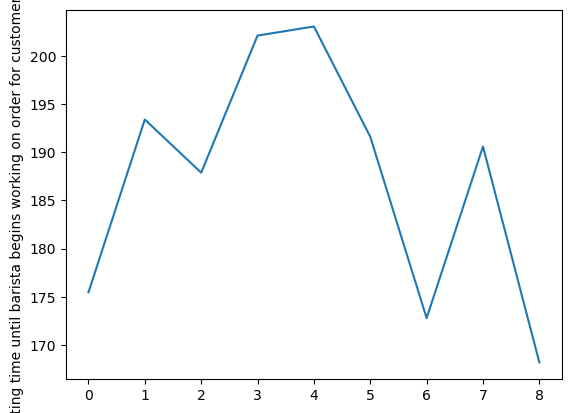

In [94]:
plt.plot(statistics.total_time_in_system)
plt.ylabel('Waiting time for customers 0 to i')
plt.show()

plt.plot(statistics.register_queue_time)
plt.ylabel('Waiting time in register queue for customers 0 to i')
plt.show()

plt.plot(statistics.pickup_queue_time)
plt.ylabel('Waiting time in pickup queue for customers 0 to i')
plt.show()

plt.plot(statistics.time_until_prep_begins)
plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
plt.show()

... the issue does seem be that of too few registers, with the model as it is right now.

# Experiment #1: Add one more register.

lalala

In [ ]:
env = simpy.Environment()

num_registers = 2 # <-- CHANGE IS HERE!!!
num_baristas = 2
num_pickups = 1

statistics = Stats()

register = simpy.Resource(env, capacity=num_registers)      # Note: SimPy resources are FIFO by default.
barista = simpy.Resource(env, capacity=num_baristas)        # We have [CAPACITY] amount of baristas, each can focus on one order at a time.
pickup = simpy.Resource(env, capacity=num_pickups)          # One can pick up their order at a time.

env.process(arrivals_generator(
    env=env, 
    stats_keeper=statistics,
    register=register, 
    barista=barista,
    pickup=pickup,
    rates=rates, 
    closing_time=closing_time,
    seed=360
))
env.run(until=1000)  # TODO: NOTE: way beyond closing time. I just wanted to see how much would be done in this time. People stop coming in after closing.

0 arrives at 2.90
0 begins ordering at 2.90
1 arrives at 10.67
1 begins ordering at 10.67
2 arrives at 16.23
2 begins ordering at 16.23
3 arrives at 18.57
4 arrives at 34.90
5 arrives at 40.35
1 finishes ordering at 43.70
1's order preperation begins at 43.70
3 begins ordering at 43.70
0 finishes ordering at 44.67
0's order preperation begins at 44.67
4 begins ordering at 44.67
6 arrives at 51.44
7 arrives at 57.99
2 finishes ordering at 61.92
5 begins ordering at 61.92
8 arrives at 64.37
9 arrives at 70.50
10 arrives at 77.63
3 finishes ordering at 87.31
6 begins ordering at 87.31
5 finishes ordering at 97.32
7 begins ordering at 97.32
4 finishes ordering at 103.43
8 begins ordering at 103.43
11 arrives at 103.69
12 arrives at 104.12
13 arrives at 104.25
14 arrives at 108.45
15 arrives at 108.81
16 arrives at 110.68
17 arrives at 114.33
18 arrives at 114.84
19 arrives at 115.79
20 arrives at 117.31
21 arrives at 118.11
22 arrives at 119.04
23 arrives at 119.31
24 arrives at 119.92
25 

### Stats display.

I should probably make a helper function for this.

Total times in register queue:
 [0.0, 0.0, 0.0, 25.132744719243043, 21.56786506148552, 9.771601524059463, 39.32533680599523, 35.86444935563412, 39.068137224905186, 50.75046604070644]
Time from when the order is placed until a barista begins working on it:
 [162.89767525535083, 175.46491668519067, 179.32306470304871, 171.78849441341504, 178.3454513180572, 203.03489162049766, 170.33334534649725, 204.4505033240896, 166.72381146886437, 174.1216509581741]
Total times in pickup queue:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total times in system:
 [210.66817088711392, 213.6389650460853, 374.5019325838561, 377.82356664583466, 528.2131705859395, 564.0565909774274, 710.3892796939906, 722.5809360884801, 871.8003127441875, 872.6129969373951]


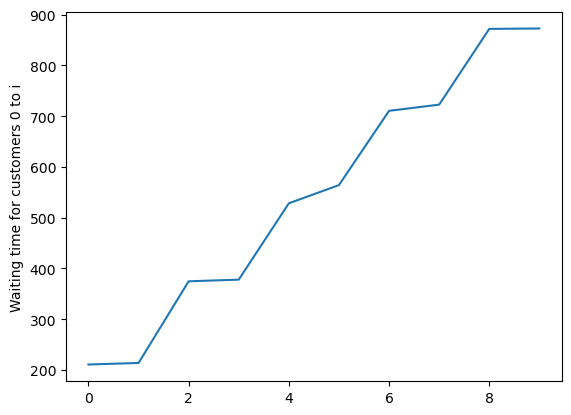

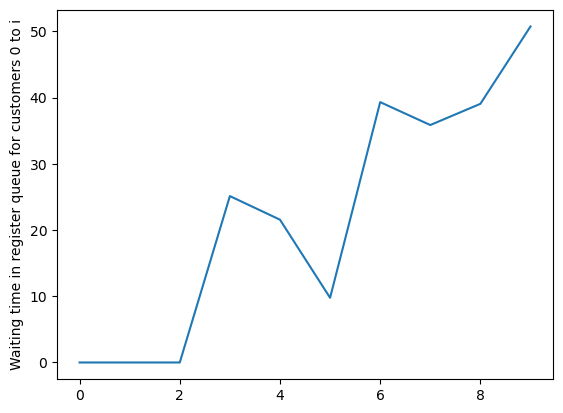

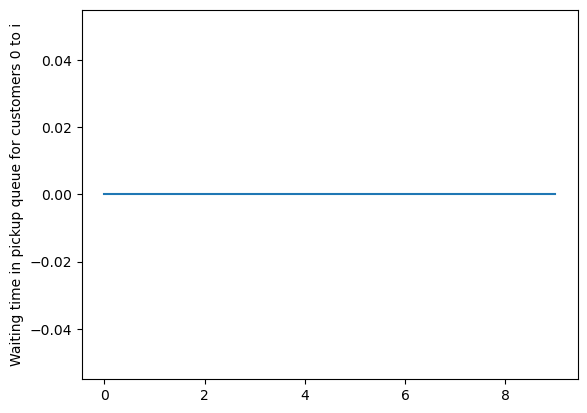

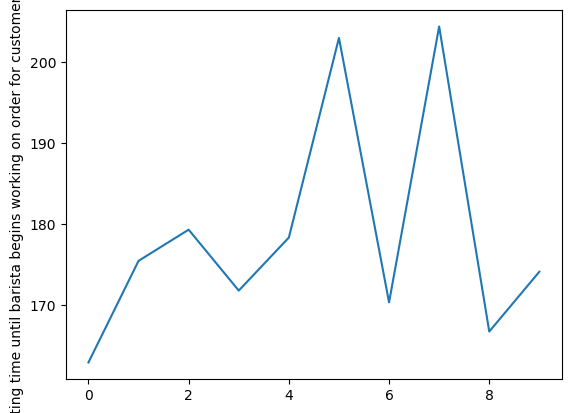

In [96]:
print("Total times in register queue:\n", statistics.register_queue_time)
print("Time from when the order is placed until a barista begins working on it:\n", statistics.time_until_prep_begins)
print("Total times in pickup queue:\n", statistics.pickup_queue_time)
print("Total times in system:\n", statistics.total_time_in_system)

plt.plot(statistics.total_time_in_system)
plt.ylabel('Waiting time for customers 0 to i')
plt.show()

plt.plot(statistics.register_queue_time)
plt.ylabel('Waiting time in register queue for customers 0 to i')
plt.show()

plt.plot(statistics.pickup_queue_time)
plt.ylabel('Waiting time in pickup queue for customers 0 to i')
plt.show()

plt.plot(statistics.time_until_prep_begins)
plt.ylabel('Waiting time until barista begins working on order for customers 0 to i')
plt.show()

... well something went wrong here. A negative number of waiting? How?
Adding a register also doesn't really seem to be making things significantly better.

# TODOS:

- Make a function called something like "simulate" or "run_simulation", where all of the inputs are things we defined as inputs in the docs file.
- Make other little helpers, like ones to graph all of the stats.